In [6]:
%cd open-images-v5

/mnt/data/object_detection/open-images


# Format annotation

- https://detectron2.readthedocs.io/tutorials/datasets.html
- https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

```
# Example of a Detectron2 label for image "1e2c50b991a82ee8.jpg"
[{'annotations': [{'bbox': [228.0, 12.0, 791.0, 858.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 0}],
  'file_name': './cmaker-fireplace-valid/1e2c50b991a82ee8.jpg', # this will change depending on where your images are stored
  'height': 867,
  'image_id': 33,
  'width': 1024}]
```

In [13]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import glob
import re
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

In [15]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(im)
    plt.axis('off');

In [16]:
# Move images in subfolders to main train/validation folders
for folder in ['train', 'validation']:
    !mv $folder/Camera/* $folder
    !rmdir $folder/Camera
    !mv $folder/Tripod/* $folder
    !rmdir $folder/Tripod

In [7]:
# Specify target classes and create `class2id` dictionary
target_classes = ['Camera', 'Tripod']
class2id = {class_: id_ for id_, class_ in enumerate(target_classes)}

# Get LabelName of target classes
classes = pd.read_csv("class-descriptions-boxable.csv", header=None, names=['LabelName', 'Class'])
subset_classes =classes[classes['Class'].isin(target_classes)]
subset_classes

,LabelName,Class
370,/m/073bxn,Tripod
498,/m/0dv5r,Camera


In [75]:
# Prepare annotation files
for folder in ['train', 'validation']:
    # Load data
    annot_df = pd.read_csv(f"{folder}-annotations-bbox.csv")
    # Merge to keep only target_classes
    annot_df = annot_df.merge(subset_classes, on='LabelName')
    # Create `ClassID` column
    annot_df['ClassID'] = annot_df['Class'].apply(lambda x: class2id[x])
    # Save truncated annot_df
    annot_df.to_csv(f"{folder}-annotations-bbox-truncated.csv")
    del annot_df

In [8]:
def bbox_rel_to_abs(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Args:
        bbox (array): relative bounding box in format (x0, x1, y0, y1)
        height (int): height of image
        width (int): width of image
    Return:
        List of absolute bounding box values in format (x0, y0, x1, y1)
    """
    x0 = np.round(np.multiply(bbox[0], width))
    x1 = np.round(np.multiply(bbox[1], width))
    y0 = np.round(np.multiply(bbox[2], height))
    y1 = np.round(np.multiply(bbox[3], height))
    return [x0, y0, x1, y1]

In [9]:
def get_detectron_dicts(img_dir):
    """
    Create a Detectron2's standard dataset dicts from an image folder.
    See: https://detectron2.readthedocs.io/tutorials/datasets.html
    
    Args:
        img_dir (str): path to the image folder (train/validation)
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    
    # Load annotation DataFrame
    annot_df = pd.read_csv(f"{img_dir}-annotations-bbox-truncated.csv")
    
    # Get all images in `img_dir`
    img_paths = glob.glob(f'{img_dir}/*.jpg')
    
    dataset_dicts = []
    for path in tqdm(img_paths):
        file_name = path
        height, width = cv2.imread(file_name).shape[:2]
        # Get image id from file_name
        img_id = re.findall(f"{img_dir}/(.*).jpg", file_name)[0]
            
        record = {}
        record['file_name'] = file_name
        record['image_id'] = img_id
        record['height'] = height
        record['width'] = width
        
        # Extract bboxes from annotation file
        bboxes = annot_df[['ClassID', 'XMin', 'XMax', 'YMin','YMax']][annot_df['ImageID'] == img_id].values
        annots = []
        for bbox in bboxes:
            # Calculate absolute bounding box
            abs_bbox = bbox_rel_to_abs(bbox[1:], height, width)
            annot = {
                "bbox": abs_bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(bbox[0]),
            }
            annots.append(annot)

        record["annotations"] = annots
        dataset_dicts.append(record)
    return dataset_dicts

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog

for d in ["train", "validation"]:
    dataset_name = "camera_tripod_" + d
    print("Registering ", dataset_name)
    DatasetCatalog.register(dataset_name, lambda d=d: get_detectron_dicts("./" + d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)

detectron_metadata = MetadataCatalog.get("camera_tripod_train")

Registering  camera_tripod_train
Registering  camera_tripod_validation


In [11]:
dataset_dicts = get_detectron_dicts("validation")

100%|██████████| 166/166 [00:02<00:00, 66.41it/s]


In [17]:
dataset_dicts[0]

{'file_name': 'validation/01284dd8eaad0569.jpg',
 'image_id': '01284dd8eaad0569',
 'height': 1024,
 'width': 1024,
 'annotations': [{'bbox': [298.0, 329.0, 778.0, 1024.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1},
  {'bbox': [105.0, 54.0, 896.0, 307.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}]}

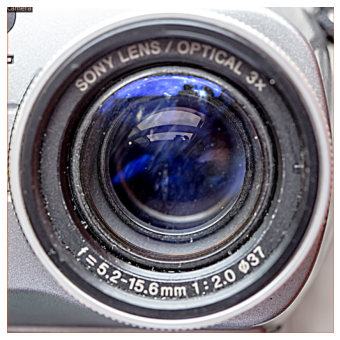

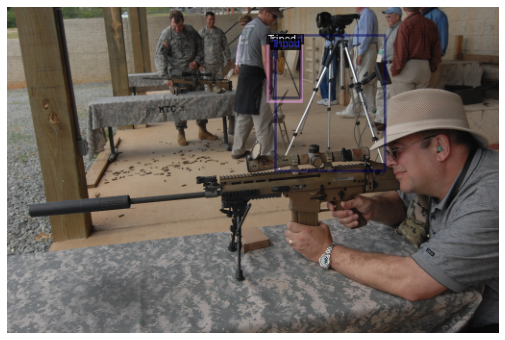

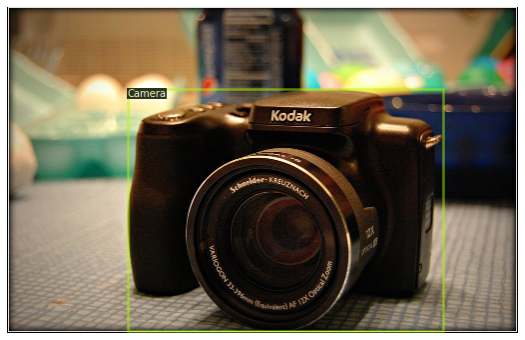

In [16]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=detectron_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1]);